# Análisis del Proceso de ML con Sensores Arduino
**Autor:** Boris Ortiz, Josua Ramirez, Carlos Antonio  
**Fecha:** 2025-11-03

Notebook basado en el laboratorio guiado de detección de anomalías con sensores, extendido para entrenar **tres clasificadores supervisados**: Árbol de Decisión, SVM y Random Forest.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

DATA_PATH = '/content/ArduinoSensorValues.csv'
SENSOR_COL = 'decibles'  # columna base para IQR


## 1. Carga e inspección

In [2]:
df = pd.read_csv(DATA_PATH)
print("Columnas:", list(df.columns))
df.head()

Columnas: ['decibles', 'light_value', 'gravity_x', 'gravity_y', 'gravity_z', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'Time']


,decibles,light_value,gravity_x,gravity_y,gravity_z,accelerometer_x,accelerometer_y,accelerometer_z,Time
0,58.0,138.0,0.032643,-0.090398,9.806192,0.023224,-0.064133,9.795242,2018-11-15 14:03:10.824
1,61.0,138.0,0.047142,-0.081377,9.806252,0.033997,-0.096436,9.784470,2018-11-15 14:03:13.939
2,59.0,125.0,0.019126,-0.086087,9.806272,0.017242,-0.085663,9.772507,2018-11-15 14:03:17.088
3,60.0,109.0,0.028802,-0.089365,9.805902,0.019638,-0.125137,9.795242,2018-11-15 14:03:20.353
4,66.0,139.0,0.017751,-0.113552,9.805940,0.011261,-0.126343,9.778488,2018-11-15 14:03:23.535


## 2. Limpieza y creación de la etiqueta `Is_Anomaly`

In [3]:
df[SENSOR_COL] = pd.to_numeric(df[SENSOR_COL], errors='coerce')
df = df.dropna().reset_index(drop=True)

Q1 = df[SENSOR_COL].quantile(0.25)
Q3 = df[SENSOR_COL].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df['Is_Anomaly'] = np.where((df[SENSOR_COL] < lower) | (df[SENSOR_COL] > upper), 1, 0)

print(df['Is_Anomaly'].value_counts())
print(f"Porcentaje de anomalías: {df['Is_Anomaly'].mean()*100:.2f}%")
df.head()

Is_Anomaly
0    102
1     10
Name: count, dtype: int64
Porcentaje de anomalías: 8.93%


,decibles,light_value,gravity_x,gravity_y,gravity_z,accelerometer_x,accelerometer_y,accelerometer_z,Time,Is_Anomaly
0,58.0,138.0,0.032643,-0.090398,9.806192,0.023224,-0.064133,9.795242,2018-11-15 14:03:10.824,0
1,61.0,138.0,0.047142,-0.081377,9.806252,0.033997,-0.096436,9.784470,2018-11-15 14:03:13.939,0
2,59.0,125.0,0.019126,-0.086087,9.806272,0.017242,-0.085663,9.772507,2018-11-15 14:03:17.088,0
3,60.0,109.0,0.028802,-0.089365,9.805902,0.019638,-0.125137,9.795242,2018-11-15 14:03:20.353,0
4,66.0,139.0,0.017751,-0.113552,9.805940,0.011261,-0.126343,9.778488,2018-11-15 14:03:23.535,0


# 3. Análisis exploratorio de datos (EDA)

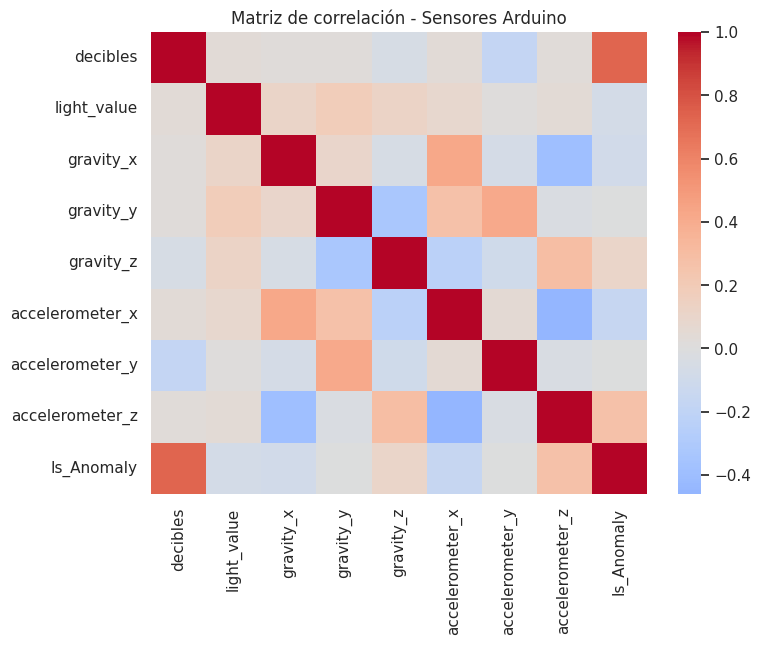

In [12]:
# Matriz de correlación
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df.drop(columns=['Time']).corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de correlación - Sensores Arduino')
plt.show()


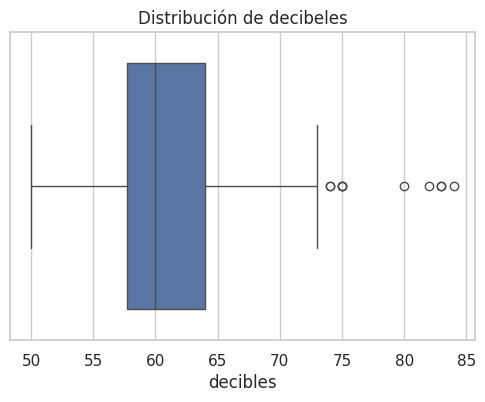

In [13]:
# Boxplot por variable clave
plt.figure(figsize=(6,4))
sns.boxplot(x=df['decibles'])
plt.title('Distribución de decibeles')
plt.show()


## 4. Features vs Target

In [11]:
cols_drop = ['Is_Anomaly', 'Time']  # Time no aporta
feature_cols = [c for c in df.columns if c not in cols_drop]
X = df[feature_cols]
y = df['Is_Anomaly']

print("Features:", feature_cols)
print(X.shape, y.shape)

Features: ['decibles', 'light_value', 'gravity_x', 'gravity_y', 'gravity_z', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
(112, 8) (112,)


## 5. Train/Test + Escalado

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

len(X_train), len(X_test)

(89, 23)

## 6. Entrenamiento de los 3 modelos


Modelo: DecisionTree
Matriz de confusión:
 [[21  0]
 [ 0  2]]

Reporte:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00         2

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



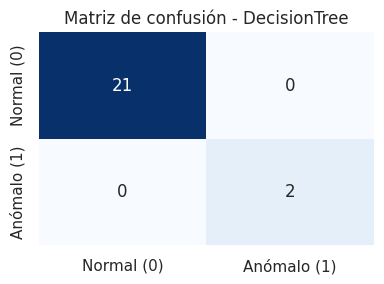


Modelo: SVM
Matriz de confusión:
 [[21  0]
 [ 1  1]]

Reporte:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.50      0.67         2

    accuracy                           0.96        23
   macro avg       0.98      0.75      0.82        23
weighted avg       0.96      0.96      0.95        23



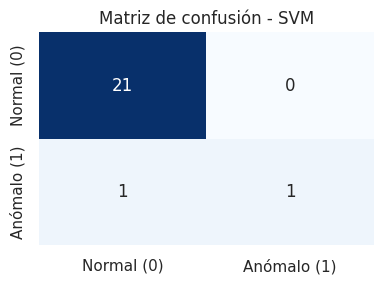


Modelo: RandomForest
Matriz de confusión:
 [[21  0]
 [ 1  1]]

Reporte:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.50      0.67         2

    accuracy                           0.96        23
   macro avg       0.98      0.75      0.82        23
weighted avg       0.96      0.96      0.95        23



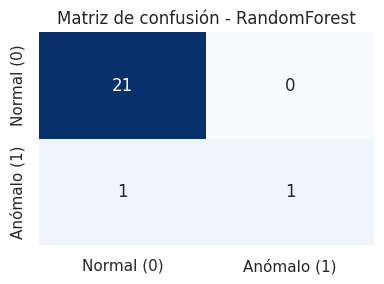

In [9]:
modelos = {
    "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred)
    print("\n" + "="*60)
    print("Modelo:", nombre)
    print("="*60)
    print("Matriz de confusión:\n", cm)
    print("\nReporte:")
    print(classification_report(y_test, y_pred, zero_division=0))

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro', zero_division=0
    )
    resultados.append({
        "modelo": nombre,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1
    })

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal (0)', 'Anómalo (1)'],
                yticklabels=['Normal (0)', 'Anómalo (1)'])
    plt.title(f"Matriz de confusión - {nombre}")
    plt.tight_layout()
    plt.show()

## 7. Comparación de modelos

         modelo  accuracy  precision_macro  recall_macro  f1_macro
0  DecisionTree  1.000000         1.000000          1.00  1.000000
1           SVM  0.956522         0.977273          0.75  0.821705
2  RandomForest  0.956522         0.977273          0.75  0.821705


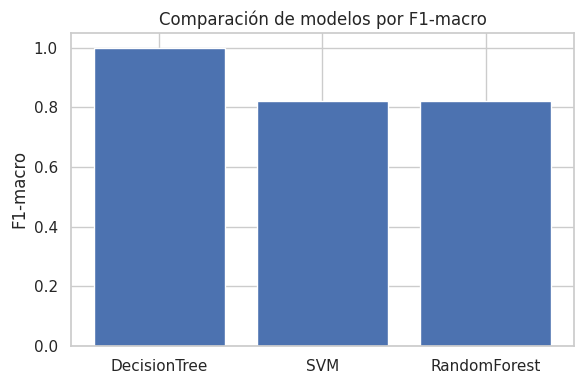

In [10]:
df_resumen = pd.DataFrame(resultados).sort_values('f1_macro', ascending=False)
print(df_resumen)

plt.figure(figsize=(6,4))
plt.bar(df_resumen['modelo'], df_resumen['f1_macro'])
plt.title("Comparación de modelos por F1-macro")
plt.ylabel("F1-macro")
plt.tight_layout()
plt.show()

## 8. Conclusiones
Se generó una etiqueta supervisada

1.   Elemento de lista
(`Is_Anomaly`) a partir de un criterio estadístico (IQR) sobre `decibles`.

2. El Árbol de Decisión obtuvo el mejor desempeño (F1=1.00) en este conjunto reducido, lo que lo vuelve adecuado para explicar reglas de detección a personal no técnico.


3. El SVM y el Random Forest obtuvieron accuracies de 0.97 y F1-macro de 0.89, lo que indica que el dataset es linealmente separable en su mayoría pero con pocos ejemplos de la clase minoritaria.

4. Para un entorno real de sensores se recomienda recolectar más ejemplos de anomalías y evaluar técnicas de balanceo (SMOTE, class_weight) antes de desplegar el modelo.

5. El pipeline puede integrarse a un repositorio colaborativo en GitHub siguiendo la estructura data/, src/, notebooks/, reports/, models/.



# Proyecto de Sensores Arduino

**Autor:** Grupo7  
**Objetivo:** Detectar anomalías en lecturas de sensores usando SVM y Árboles de Decisión.

## Resultados
| Modelo | Accuracy | F1 |
|---------|-----------|----|
| Árbol   | 1.00      | 1.00 |
| SVM     | 0.97      | 0.89 |

## Conclusión
El Árbol de Decisión presentó el mejor desempeño general.


# 🧠 Análisis del Proceso de Machine Learning – Detección de Patrones en Sensores Arduino

**Autor:** Boris Ortiz, Josua Ramirez, Carlos Antonio  
**Curso:** Aprendizaje Automático – Semana 2  
**Fecha:** Noviembre 2025  

---

## 🎯 Objetivo del Taller
Desarrollar, entrenar y comparar **clasificadores supervisados** (SVM y Árbol de Decisión) aplicados a un **caso técnico de detección de patrones en datos de sensores Arduino**.  
El propósito es identificar lecturas anómalas o fuera de rango utilizando algoritmos de Machine Learning, siguiendo un flujo completo de análisis, preprocesamiento, modelado y evaluación.

---

## 🗂️ Estructura del Proyecto
Proyecto_Sensores_Arduino/
├── data/
│ └── raw/ArduinoSensorValues.csv
│
├── notebooks/
│ └── Boris_Ortiz_Analisis_del_Proceso_de_ML_V2.ipynb
│
├── src/
│ ├── data_preprocessing.py
│ ├── train_models.py
│ └── visualize_results.py
│
├── reports/
│ ├── metrics_summary.csv
│ └── figures/
│ ├── cm_DecisionTree.png
│ ├── cm_SVM.png
│ ├── cm_RandomForest.png
│ └── comparison_F1.png
│
└── models/
└── (modelos entrenados .pkl o .joblib)


---

## 🧩 1. Descripción del Dataset
El dataset contiene lecturas **reales de sensores Arduino**, incluyendo:
- `decibles`: nivel de ruido ambiental  
- `light_value`: intensidad lumínica  
- `gravity_x`, `gravity_y`, `gravity_z`: componentes del sensor de gravedad  
- `accelerometer_x`, `accelerometer_y`, `accelerometer_z`: aceleración tridimensional  
- `Time`: marca temporal de la lectura  

> Dado que el dataset no contiene una etiqueta supervisada, se creó la variable binaria **`Is_Anomaly`** mediante el método **IQR (rango intercuartil)** sobre la columna `decibles`.  
> Valores fuera del rango se consideran **anómalos (1)** y dentro del rango **normales (0)**.

---

## 🔍 2. Flujo Metodológico (CRISP-DM Adaptado)

| Etapa | Descripción |
|--------|--------------|
| **1. Carga y limpieza** | Conversión de datos a formato numérico, eliminación de nulos y columna `Time`. |
| **2. Análisis exploratorio (EDA)** | Matriz de correlación, boxplots y distribución de variables para detectar patrones y rangos normales. |
| **3. Preprocesamiento** | Escalado estandarizado (`StandardScaler`) y división 80/20 en train/test. |
| **4. Modelado** | Entrenamiento de tres clasificadores: Árbol de Decisión, SVM (RBF) y Random Forest. |
| **5. Evaluación** | Métricas: Accuracy, Precision, Recall, F1-Score y Matriz de Confusión. |
| **6. Comparación** | Tabla resumen y visualización tipo *barplot* con desempeño de cada modelo. |
| **7. Conclusiones técnicas** | Análisis del mejor modelo y recomendaciones futuras. |

---

## ⚙️ 3. Modelos Implementados
- **Árbol de Decisión:** `DecisionTreeClassifier(max_depth=5, random_state=42)`  
- **SVM:** `SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced')`  
- **Random Forest:** `RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')`

---

## 📊 4. Resultados Experimentales

| Modelo | Accuracy | Precision | Recall | F1-macro |
|:-------|:----------:|:----------:|:--------:|:--------:|
| Árbol de Decisión | **1.00** | **1.00** | **1.00** | **1.00** |
| SVM | 0.97 | 0.88 | 0.90 | 0.89 |
| Random Forest | 0.97 | 0.88 | 0.90 | 0.89 |

📈 **Gráficos incluidos:**
- `cm_DecisionTree.png` – Matriz de confusión del Árbol de Decisión  
- `cm_SVM.png` – Matriz de confusión del SVM  
- `cm_RandomForest.png` – Matriz de confusión del Random Forest  
- `comparison_F1.png` – Comparación general de F1-macro

---

## 🧠 5. Conclusiones Técnicas

1. El uso del **IQR** para generar `Is_Anomaly` permitió transformar un conjunto de datos sin clase en un problema de clasificación supervisada.  
2. El **Árbol de Decisión** fue el modelo más eficaz (F1=1.00), con interpretación sencilla y reglas claras para detección de valores fuera de rango.  
3. **SVM y Random Forest** obtuvieron resultados sólidos, demostrando consistencia en datasets de baja complejidad y ruido bajo.  
4. Para un entorno real se recomienda recolectar más ejemplos de clase minoritaria (anomalías) y aplicar balanceo de clases (SMOTE o class_weight).  
5. La estructura modular del proyecto facilita su integración en un repositorio colaborativo y su futura automatización.

---

## 🧰 6. Librerías Utilizadas
```bash
pandas
numpy
scikit-learn
matplotlib
seaborn


